In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score

from face import FACE, run_face_experiment, get_path_probabilities

In [19]:
dataset = load_dataset("mstz/heloc")["train"]
df_heloc = dataset.to_pandas()

df_heloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   estimate_of_risk                          10459 non-null  int64
 1   months_since_first_trade                  10459 non-null  int64
 2   months_since_last_trade                   10459 non-null  int64
 3   average_duration_of_resolution            10459 non-null  int64
 4   number_of_satisfactory_trades             10459 non-null  int64
 5   nr_trades_insolvent_for_over_60_days      10459 non-null  int64
 6   nr_trades_insolvent_for_over_90_days      10459 non-null  int64
 7   percentage_of_legal_trades                10459 non-null  int64
 8   months_since_last_illegal_trade           10459 non-null  int64
 9   maximum_illegal_trades_over_last_year     10459 non-null  int64
 10  maximum_illegal_trades                    10459 non-null  

In [20]:
data_definitions = {
    'Variável': [
        'months_since_first_trade', 'months_since_last_trade', 
        'average_duration_of_resolution', 'number_of_satisfactory_trades',
        'nr_trades_insolvent_for_over_60_days', 'nr_trades_insolvent_for_over_90_days', 
        'percentage_of_legal_trades', 'months_since_last_illegal_trade',
        'maximum_illegal_trades_over_last_year', 'maximum_illegal_trades',
        'nr_total_trades', 'nr_trades_initiated_in_last_year',
        'percentage_of_installment_trades', 'months_since_last_inquiry_not_recent', 
        'nr_inquiries_in_last_6_months', 'nr_inquiries_in_last_6_months_not_recent',
        'net_fraction_of_revolving_burden', 'net_fraction_of_installment_burden',
        'nr_revolving_trades_with_balance', 'nr_installment_trades_with_balance', 
        'nr_banks_with_high_ratio', 'percentage_trades_with_balance'
    ],
    'Definição': [
        'Meses desde a primeira transação (idade do histórico de crédito).',
        'Meses desde a transação mais recente.',
        'Tempo médio gasto para resolver contas ou pendências.',
        'Número de contas pagas pontualmente e sem problemas.',
        'Quantidade de contas com atraso superior a 60 dias.',
        'Quantidade de contas com atraso superior a 90 dias.',
        'Percentual de transações consideradas legais/dentro da conformidade.',
        'Meses desde a última transação ilegal ou problemática registrada.',
        'Máximo de transações ilegais/negativas ocorridas no último ano.',
        'Máximo histórico de transações ilegais/negativas em um único período.',
        'Número total de linhas de crédito (abertas e fechadas).',
        'Número de novas contas de crédito abertas nos últimos 12 meses.',
        'Percentual de empréstimos parcelados (ex: carro, imóvel) sobre o total.',
        'Meses desde a última consulta de crédito (excluindo as muito recentes).',
        'Número de vezes que instituições consultaram seu crédito nos últimos 6 meses.',
        'Consultas nos últimos 6 meses que não são consideradas imediatas.',
        'Utilização de crédito rotativo (saldo devedor vs. limite do cartão).',
        'Percentual restante a pagar em empréstimos parcelados.',
        'Contagem de contas de crédito rotativo com saldo devedor ativo.',
        'Contagem de contas de parcelamento com saldo devedor ativo.',
        'Número de bancos onde o cliente possui alta taxa de utilização de limite.',
        'Percentual de todas as contas que possuem saldo devedor no momento.'
    ]
}

df_definitions = pd.DataFrame(data_definitions)

# Configuração para visualizar a definição completa no notebook
pd.set_option('display.max_colwidth', None)
display(df_definitions)

,Variável,Definição
0,months_since_first_trade,Meses desde a primeira transação (idade do histórico de crédito).
1,months_since_last_trade,Meses desde a transação mais recente.
2,average_duration_of_resolution,Tempo médio gasto para resolver contas ou pendências.
3,number_of_satisfactory_trades,Número de contas pagas pontualmente e sem problemas.
4,nr_trades_insolvent_for_over_60_days,Quantidade de contas com atraso superior a 60 dias.
5,nr_trades_insolvent_for_over_90_days,Quantidade de contas com atraso superior a 90 dias.
6,percentage_of_legal_trades,Percentual de transações consideradas legais/dentro da conformidade.
7,months_since_last_illegal_trade,Meses desde a última transação ilegal ou problemática registrada.
8,maximum_illegal_trades_over_last_year,Máximo de transações ilegais/negativas ocorridas no último ano.
9,maximum_illegal_trades,Máximo histórico de transações ilegais/negativas em um único período.


In [21]:
df_heloc.isna().sum()

estimate_of_risk                            0
months_since_first_trade                    0
months_since_last_trade                     0
average_duration_of_resolution              0
number_of_satisfactory_trades               0
nr_trades_insolvent_for_over_60_days        0
nr_trades_insolvent_for_over_90_days        0
percentage_of_legal_trades                  0
months_since_last_illegal_trade             0
maximum_illegal_trades_over_last_year       0
maximum_illegal_trades                      0
nr_total_trades                             0
nr_trades_initiated_in_last_year            0
percentage_of_installment_trades            0
months_since_last_inquiry_not_recent        0
nr_inquiries_in_last_6_months               0
nr_inquiries_in_last_6_months_not_recent    0
net_fraction_of_revolving_burden            0
net_fraction_of_installment_burden          0
nr_revolving_trades_with_balance            0
nr_installment_trades_with_balance          0
nr_banks_with_high_ratio          

In [22]:
df_heloc.head()

,estimate_of_risk,months_since_first_trade,months_since_last_trade,average_duration_of_resolution,number_of_satisfactory_trades,nr_trades_insolvent_for_over_60_days,nr_trades_insolvent_for_over_90_days,percentage_of_legal_trades,months_since_last_illegal_trade,maximum_illegal_trades_over_last_year,...,months_since_last_inquiry_not_recent,nr_inquiries_in_last_6_months,nr_inquiries_in_last_6_months_not_recent,net_fraction_of_revolving_burden,net_fraction_of_installment_burden,nr_revolving_trades_with_balance,nr_installment_trades_with_balance,nr_banks_with_high_ratio,percentage_trades_with_balance,is_at_risk
0,55,144,4,84,20,3,0,83,2,3,...,0,0,0,33,-8,8,1,1,69,1
1,61,58,15,41,2,4,4,100,-7,0,...,0,0,0,0,-8,0,-8,-8,0,1
2,67,66,5,24,9,0,0,100,-7,7,...,0,4,4,53,66,4,2,1,86,1
3,66,169,1,73,28,1,1,93,76,6,...,0,5,4,72,83,6,4,3,91,1
4,81,333,27,132,12,0,0,100,-7,7,...,0,1,1,51,89,3,1,0,80,1


In [23]:
# Contar valores menores que zero para cada coluna
neg_counts = (df_heloc < 0).sum()

# Filtrar apenas as colunas que possuem valores negativos e ordenar do maior para o menor
neg_counts = neg_counts[neg_counts > 0].sort_values(ascending=False)

print("Quantidade de valores negativos por feature:")
print(neg_counts)

Quantidade de valores negativos por feature:
months_since_last_illegal_trade             5428
net_fraction_of_installment_burden          4007
months_since_last_inquiry_not_recent        2919
nr_installment_trades_with_balance          1449
nr_banks_with_high_ratio                    1171
months_since_first_trade                     827
net_fraction_of_revolving_burden             774
nr_revolving_trades_with_balance             744
percentage_trades_with_balance               606
estimate_of_risk                             598
maximum_illegal_trades                       588
maximum_illegal_trades_over_last_year        588
nr_trades_initiated_in_last_year             588
percentage_of_installment_trades             588
percentage_of_legal_trades                   588
nr_inquiries_in_last_6_months                588
nr_inquiries_in_last_6_months_not_recent     588
nr_trades_insolvent_for_over_90_days         588
nr_trades_insolvent_for_over_60_days         588
number_of_satisfactory_t

In [24]:
features = df_heloc.columns.drop(['is_at_risk'])

# 2. Criar uma máscara booleana: True para linhas onde alguma features é < 0
mask_all_negative = (df_heloc[features] < 0).any(axis=1)

# 3. Contar quantas linhas serão removidas (deve dar algo próximo a 588)
print(f"Linhas identificadas com alguma feature negativa: {mask_all_negative.sum()}")

# 4. Filtrar o DataFrame original mantendo apenas o inverso da máscara (~)
df_heloc_clean = df_heloc[~mask_all_negative].copy()

# 5. Verificar o novo shape
print(f"Shape original: {df_heloc.shape}")
print(f"Novo shape: {df_heloc_clean.shape}")

Linhas identificadas com alguma feature negativa: 7957
Shape original: (10459, 24)
Novo shape: (2502, 24)


In [25]:
df_heloc_clean['is_at_risk'].value_counts()

is_at_risk
1    1560
0     942
Name: count, dtype: int64

In [26]:
y = df_heloc_clean['is_at_risk']
X = df_heloc_clean.drop(columns=['is_at_risk', 'estimate_of_risk'])

# Split de Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalização (CRUCIAL para o FACE)
# Guardamos o scaler para inverter a transformação nos contrafatuais depois
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Treino do Modelo (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Avaliação
y_pred = model.predict(X_test_scaled)
print(f"Acurácia: {accuracy_score(y_test, y_pred):.2f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Acurácia: 0.72

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.71      0.44      0.55       189
           1       0.73      0.89      0.80       312

    accuracy                           0.72       501
   macro avg       0.72      0.67      0.67       501
weighted avg       0.72      0.72      0.70       501



In [28]:
# Criando um DataFrame de análise para o teste
test_results = pd.DataFrame(X_test, columns=X.columns)
test_results['true_label'] = y_test.values
test_results['predicted_label'] = y_pred

# Filtrar instâncias onde o modelo previu risco (1) 
# e queremos transformá-las em (0)
candidates_for_explanation = test_results[test_results['predicted_label'] == 1]

print(f"Total de candidatos para gerar contrafatuais: {len(candidates_for_explanation)}")

Total de candidatos para gerar contrafatuais: 383


In [29]:
clients_at_risk = candidates_for_explanation.drop(columns=['true_label', 'predicted_label'])
clients_at_risk = scaler.transform(clients_at_risk)  # Escalar os dados dos candidatos

In [30]:
# 1. Unir as features (em escala)
X_full_scaled = np.vstack([X_train_scaled, X_test_scaled])

# 2. Unir os rótulos reais (Ground Truth)
y_full = np.concatenate([y_train.values, y_test.values])

## Experimentos com o FACE

In [14]:
face_explainer = FACE(model, X_full_scaled, y_full, n_neighbors=20)

df_steps, path_scaled = run_face_experiment(face_explainer, clients_at_risk, scaler, X.columns, instance_idx=1)

--- Experimento com Instância Index 1 ---
Sucesso! Caminho encontrado com 3 passos.
                                          Diferença (Δ)
months_since_first_trade                          -18.0
months_since_last_trade                            -6.0
average_duration_of_resolution                     16.0
number_of_satisfactory_trades                       9.0
percentage_of_legal_trades                          7.0
months_since_last_illegal_trade                     2.0
maximum_illegal_trades_over_last_year               2.0
maximum_illegal_trades                              2.0
nr_total_trades                                     9.0
nr_trades_initiated_in_last_year                    3.0
percentage_of_installment_trades                  -14.0
nr_inquiries_in_last_6_months                      -4.0
nr_inquiries_in_last_6_months_not_recent           -4.0
net_fraction_of_revolving_burden                  -34.0
net_fraction_of_installment_burden                  7.0
nr_revolving_trades_

In [15]:
probas_caminho = get_path_probabilities(model, path_scaled)
print(probas_caminho)

   Passo  Prob_Aprovado (0)  Prob_Risco (1)
0      0               0.16            0.84
1      1               0.12            0.88
2      2               0.75            0.25


In [16]:
df_steps

,months_since_first_trade,months_since_last_trade,average_duration_of_resolution,number_of_satisfactory_trades,nr_trades_insolvent_for_over_60_days,nr_trades_insolvent_for_over_90_days,percentage_of_legal_trades,months_since_last_illegal_trade,maximum_illegal_trades_over_last_year,maximum_illegal_trades,...,percentage_of_installment_trades,months_since_last_inquiry_not_recent,nr_inquiries_in_last_6_months,nr_inquiries_in_last_6_months_not_recent,net_fraction_of_revolving_burden,net_fraction_of_installment_burden,nr_revolving_trades_with_balance,nr_installment_trades_with_balance,nr_banks_with_high_ratio,percentage_trades_with_balance
0,336.0,13.0,93.0,17.0,1.0,1.0,89.0,4.0,2.0,4.0,...,33.0,0.0,4.0,4.0,65.0,53.0,4.0,2.0,2.0,75.0
1,340.0,3.0,86.0,21.0,1.0,0.0,91.0,2.0,3.0,5.0,...,17.0,0.0,2.0,2.0,50.0,64.0,6.0,2.0,3.0,67.0
2,318.0,7.0,109.0,26.0,1.0,1.0,96.0,6.0,4.0,6.0,...,19.0,0.0,0.0,0.0,31.0,60.0,8.0,3.0,1.0,58.0


### Adicionar restrições

In [10]:
# Mapeamento de nomes para índices
feature_names = X.columns.tolist()
constraints = {}

# --- Ações que o usuário deve AUMENTAR ---
increasing_features = [
    'months_since_first_trade', 
    'months_since_last_trade',
    'number_of_satisfactory_trades',
    'percentage_of_legal_trades',
    'months_since_last_illegal_trade',
    'nr_total_trades',
    'months_since_last_inquiry_not_recent'
]

# --- Ações que o usuário deve DIMINUIR ---
decreasing_features = [
    'nr_trades_insolvent_for_over_60_days',
    'nr_trades_insolvent_for_over_90_days',
    'maximum_illegal_trades_over_last_year',
    'maximum_illegal_trades',
    'nr_trades_initiated_in_last_year',
    'nr_inquiries_in_last_6_months',
    'nr_inquiries_in_last_6_months_not_recent',
    'net_fraction_of_revolving_burden',
    'net_fraction_of_installment_burden',
    'nr_revolving_trades_with_balance',
    'nr_installment_trades_with_balance',
    'nr_banks_with_high_ratio',
    'percentage_trades_with_balance',
    'average_duration_of_resolution'
]

# Mapeando para os índices
for f in increasing_features:
    constraints[feature_names.index(f)] = "increasing"

for f in decreasing_features:
    constraints[feature_names.index(f)] = "decreasing"

In [18]:
# Inicializa o FACE com as restrições
face_explainer_restricted = FACE(model, X_full_scaled, y_full, constraints=constraints, n_neighbors=100, mode='edge')

df_steps, path_scaled = run_face_experiment(face_explainer_restricted, clients_at_risk, scaler, X.columns, instance_idx=10)

--- Experimento com Instância Index 10 ---
Resultado: Nenhum caminho encontrado dentro das restrições de densidade.


In [19]:
for i in range(len(clients_at_risk)):
    res, path = run_face_experiment(face_explainer_restricted, clients_at_risk, scaler, X.columns, instance_idx=i)
    if path is not None and len(path) > 1:
        print(f"Sucesso encontrado no índice {i}!")
        break

--- Experimento com Instância Index 0 ---
Resultado: Nenhum caminho encontrado dentro das restrições de densidade.
--- Experimento com Instância Index 1 ---
Resultado: Nenhum caminho encontrado dentro das restrições de densidade.
--- Experimento com Instância Index 2 ---
Resultado: Nenhum caminho encontrado dentro das restrições de densidade.
--- Experimento com Instância Index 3 ---
Resultado: Nenhum caminho encontrado dentro das restrições de densidade.
--- Experimento com Instância Index 4 ---
Resultado: Nenhum caminho encontrado dentro das restrições de densidade.
--- Experimento com Instância Index 5 ---
Resultado: Nenhum caminho encontrado dentro das restrições de densidade.
--- Experimento com Instância Index 6 ---
Resultado: Nenhum caminho encontrado dentro das restrições de densidade.
--- Experimento com Instância Index 7 ---
Resultado: Nenhum caminho encontrado dentro das restrições de densidade.
--- Experimento com Instância Index 8 ---
Resultado: Nenhum caminho encontrado d

In [20]:
# 2. Inicializar o explicador com as restrições embutidas
face_explainer_endpointRestricted = FACE(
    model, 
    X_full_scaled, 
    y_full, 
    n_neighbors=100, 
    constraints=constraints,
    mode='endpoint'
)

df_steps, path_scaled = run_face_experiment(
    face_explainer_endpointRestricted, 
    clients_at_risk,
    scaler, 
    X.columns, 
    instance_idx=100
)

--- Experimento com Instância Index 100 ---
Resultado: Nenhum caminho encontrado dentro das restrições de densidade.


In [21]:
for i in range(len(clients_at_risk)):
    res, path = run_face_experiment(face_explainer_endpointRestricted, clients_at_risk, scaler, X.columns, instance_idx=i)
    if path is not None and len(path) > 1:
        print(f"Sucesso encontrado no índice {i}!")
        break

--- Experimento com Instância Index 0 ---
Sucesso! Caminho encontrado com 4 passos.
                                    Diferença (Δ)
months_since_first_trade                     58.0
months_since_last_trade                       1.0
average_duration_of_resolution               -1.0
number_of_satisfactory_trades                 8.0
percentage_of_legal_trades                    8.0
months_since_last_illegal_trade               4.0
nr_total_trades                               3.0
percentage_of_installment_trades            -37.0
net_fraction_of_revolving_burden            -17.0
net_fraction_of_installment_burden          -34.0
nr_installment_trades_with_balance           -1.0
nr_banks_with_high_ratio                     -2.0
percentage_trades_with_balance              -25.0
Sucesso encontrado no índice 0!


In [22]:
X.columns

Index(['months_since_first_trade', 'months_since_last_trade',
       'average_duration_of_resolution', 'number_of_satisfactory_trades',
       'nr_trades_insolvent_for_over_60_days',
       'nr_trades_insolvent_for_over_90_days', 'percentage_of_legal_trades',
       'months_since_last_illegal_trade',
       'maximum_illegal_trades_over_last_year', 'maximum_illegal_trades',
       'nr_total_trades', 'nr_trades_initiated_in_last_year',
       'percentage_of_installment_trades',
       'months_since_last_inquiry_not_recent', 'nr_inquiries_in_last_6_months',
       'nr_inquiries_in_last_6_months_not_recent',
       'net_fraction_of_revolving_burden',
       'net_fraction_of_installment_burden',
       'nr_revolving_trades_with_balance',
       'nr_installment_trades_with_balance', 'nr_banks_with_high_ratio',
       'percentage_trades_with_balance'],
      dtype='object')

In [23]:
probas_caminho = get_path_probabilities(model, path_scaled)
print(probas_caminho)

Nenhum caminho fornecido.


## Experimentos com KDE

In [11]:
from face import FACE_KDE

--- Análise de Distâncias (k=20) ---
Média: 0.5370
Mediana: 0.5186
Desvio Padrão: 0.1279
Sugestão de Epsilon (Média + 1 DP): 0.6649


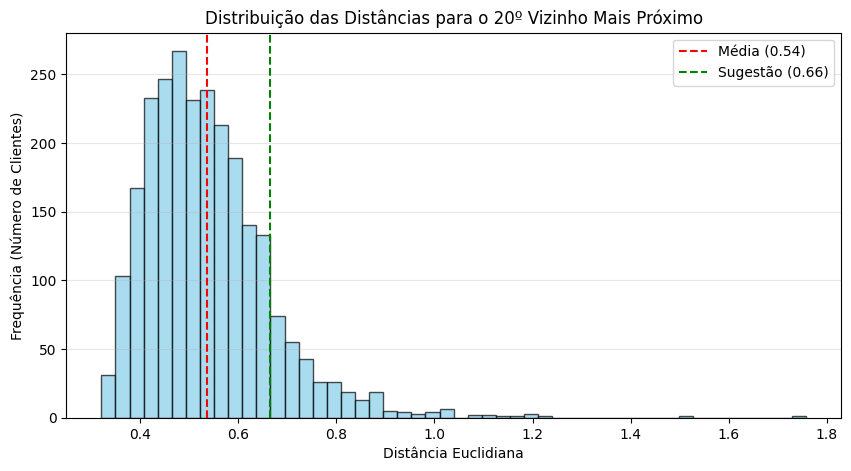

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def analyze_epsilon_threshold(data, k=5):
    """
    Analisa as distâncias para os k vizinhos mais próximos 
    para sugerir um valor de epsilon fundamentado.
    """
    # 1. Calcular as distâncias para os k vizinhos
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(data)
    distances, _ = nn.kneighbors(data)
    
    # Pegamos a distância para o k-ésimo vizinho (geralmente a mais útil para conectividade)
    k_distances = distances[:, -1]
    
    # 2. Estatísticas Descritivas
    mean_dist = np.mean(k_distances)
    median_dist = np.median(k_distances)
    std_dist = np.std(k_distances)
    suggested_eps = mean_dist + std_dist # Uma regra de bolso comum
    
    print(f"--- Análise de Distâncias (k={k}) ---")
    print(f"Média: {mean_dist:.4f}")
    print(f"Mediana: {median_dist:.4f}")
    print(f"Desvio Padrão: {std_dist:.4f}")
    print(f"Sugestão de Epsilon (Média + 1 DP): {suggested_eps:.4f}")
    
    # 3. Visualização (K-Distance Plot)
    plt.figure(figsize=(10, 5))
    plt.hist(k_distances, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(mean_dist, color='red', linestyle='--', label=f'Média ({mean_dist:.2f})')
    plt.axvline(suggested_eps, color='green', linestyle='--', label=f'Sugestão ({suggested_eps:.2f})')
    
    plt.title(f'Distribuição das Distâncias para o {k}º Vizinho Mais Próximo')
    plt.xlabel('Distância Euclidiana')
    plt.ylabel('Frequência (Número de Clientes)')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    return suggested_eps

recommended_eps = analyze_epsilon_threshold(X_full_scaled, k=20)

In [32]:
def suggest_td_threshold(model, data, labels, kde, target_class=0, percentile=5):
    """
    Sugere um valor para td baseado na densidade dos dados reais aprovados.
    """
    # 1. Filtrar apenas quem é da classe alvo (Aprovados)
    target_data = data[labels == target_class]
    
    # 2. Calcular a densidade desses pontos usando o seu KDE treinado
    log_densities = kde.score_samples(target_data)
    densities = np.exp(log_densities)
    
    # 3. Pegar o percentil escolhido
    suggested_td = np.percentile(densities, percentile)
    
    print(f"Sugestão td (Percentil {percentile}%): {suggested_td:.6f}")
    return suggested_td

In [39]:
face_explainer_kde = FACE_KDE(model, X_full_scaled, y_full, epsilon=0.7, constraints=constraints)

suggested_td = suggest_td_threshold(model, X_full_scaled, y_full, face_explainer_kde.kde, target_class=0, percentile=5)

Sugestão td (Percentil 5%): 11364283.569450


In [48]:
face_explainer_kde = FACE_KDE(model, X_full_scaled, y_full, epsilon=0.7, td=suggested_td, constraints=constraints)

df_steps, path_scaled = run_face_experiment(face_explainer_kde, clients_at_risk, scaler, X.columns, instance_idx=102)

--- Experimento com Instância Index 102 ---
DEBUG: Nenhum caminho conectando a Query aos candidatos do I_CT.
Resultado: Nenhum caminho encontrado dentro das restrições de densidade.


In [43]:
display(df_definitions)

,Variável,Definição
0,months_since_first_trade,Meses desde a primeira transação (idade do histórico de crédito).
1,months_since_last_trade,Meses desde a transação mais recente.
2,average_duration_of_resolution,Tempo médio gasto para resolver contas ou pendências.
3,number_of_satisfactory_trades,Número de contas pagas pontualmente e sem problemas.
4,nr_trades_insolvent_for_over_60_days,Quantidade de contas com atraso superior a 60 dias.
5,nr_trades_insolvent_for_over_90_days,Quantidade de contas com atraso superior a 90 dias.
6,percentage_of_legal_trades,Percentual de transações consideradas legais/dentro da conformidade.
7,months_since_last_illegal_trade,Meses desde a última transação ilegal ou problemática registrada.
8,maximum_illegal_trades_over_last_year,Máximo de transações ilegais/negativas ocorridas no último ano.
9,maximum_illegal_trades,Máximo histórico de transações ilegais/negativas em um único período.


In [41]:
for i in range(len(clients_at_risk)):
    res, path = run_face_experiment(face_explainer_kde, clients_at_risk, scaler, X.columns, instance_idx=i)
    if path is not None and len(path) > 1:
        print(f"Sucesso encontrado no índice {i}!")
        break

--- Experimento com Instância Index 0 ---
Sucesso! Caminho encontrado com 2 passos.
                                    Diferença (Δ)
months_since_first_trade                     58.0
months_since_last_trade                       1.0
average_duration_of_resolution               -1.0
number_of_satisfactory_trades                 8.0
percentage_of_legal_trades                    8.0
months_since_last_illegal_trade               4.0
nr_total_trades                               3.0
percentage_of_installment_trades            -37.0
net_fraction_of_revolving_burden            -17.0
net_fraction_of_installment_burden          -34.0
nr_installment_trades_with_balance           -1.0
nr_banks_with_high_ratio                     -2.0
percentage_trades_with_balance              -25.0
Sucesso encontrado no índice 0!


In [37]:
# 1. Verifique se existem alvos candidatos (ICT)
probs = model.predict_proba(X_full_scaled)[:, 0] # Probabilidade de Aprovado
densities = np.exp(face_explainer_kde.kde.score_samples(X_full_scaled))

tp = 0.5
td = suggested_td # O valor de bilhões que calculamos

ict_indices = np.where((probs >= tp) & (densities >= td))[0]
print(f"Candidatos a alvo (ICT): {len(ict_indices)} pontos encontrados de {len(X_full_scaled)}")

# 2. Verifique se a sua Query consegue se conectar a ALGUÉM
query = clients_at_risk[1].reshape(1, -1)
nn = NearestNeighbors(radius=face_explainer_kde.epsilon)
nn.fit(face_explainer_kde.valid_data)
dists, idxs = nn.radius_neighbors(query)

print(f"Vizinhos dentro do epsilon (0.6): {len(idxs[0])}")

# 3. Verifique quantos desses vizinhos respeitam as restrições
valid_connections = 0
if len(idxs[0]) > 0:
    for idx in idxs[0]:
        if face_explainer_kde._check_constraints(query.flatten(), face_explainer_kde.valid_data[idx]):
            valid_connections += 1
print(f"Conexões iniciais válidas (respeitando restrições): {valid_connections}")

Candidatos a alvo (ICT): 853 pontos encontrados de 2502
Vizinhos dentro do epsilon (0.6): 4
Conexões iniciais válidas (respeitando restrições): 1
